In [1]:
import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import os
from tqdm import tqdm
import time
import csv
import matplotlib.pyplot as plt
print("OK")

OK


In [4]:
# --------- Initialize Parameters -------------
num_classes = 16# dataset includes 16 crop classes
epochs = 30
learning_rate = 0.0001
batch_size = 64
weight_decay = 0.0001
model_name = "transformer"
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# --------- Select CPU or GPU to run ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#--------- Check the name of the GPU --------
if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU name: Tesla V100-SXM2-16GB


In [5]:
# Load the processed data
X_train = torch.load("train_X.pt")
y_train = torch.load("train_y.pt")
X_val = torch.load("val_X.pt")
y_val = torch.load("val_y.pt")
X_test = torch.load("test_X.pt")
y_test = torch.load("test_y.pt")

# Create DataLoaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

print("Data OK")

Data OK


In [6]:
# Transformer model
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_classes, num_heads, num_layers, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.input_proj = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Sequential(
            nn.Linear(model_dim, model_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(model_dim // 2, num_classes)
        )

    def forward(self, x):
        x = self.input_proj(x)       # [B, T, input_dim] -> [B, T, model_dim]
        x = self.transformer_encoder(x)  # [B, T, model_dim]
        x = x.mean(dim=1)            # Mean over time
        return self.classifier(x)
    
# Model setup
input_dim = X_train.shape[2]
model_dim = 128
num_heads = 4
num_layers = 2
model = TimeSeriesTransformer(
    input_dim,
    model_dim,
    num_classes,
    num_heads,
    num_layers
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

print("Model OK")

Model OK


In [7]:
# Training loop with validation
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_f1s, val_f1s = [], []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    train_preds, train_targets = [], []
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]")
    for xb, yb in loop:
        xb, yb = xb.to(device), yb.to(device)
        
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        
        # Check for NaNs early
        if not torch.isfinite(loss):
            print(f"Non-finite loss detected: {loss.item()}")
            break
        
        loss.backward()
        
        # Gradient clipping for stability (essential for Transformers)
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
        train_preds.extend(preds.cpu().numpy())
        train_targets.extend(yb.cpu().numpy())
        
        loop.set_postfix(loss=loss.item(), accuracy=100 * correct / total)
    
    scheduler.step()
    
    train_loss = total_loss / len(train_loader)
    train_losses.append(train_loss)
    
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)
    
    train_f1 = f1_score(train_targets, train_preds, average='weighted', zero_division=0)*100
    train_f1s.append(train_f1)
    
    # Validation
    model.eval()
    val_loss = 0.0
    y_true, y_pred = [], []
    
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            val_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            y_true.extend(yb.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            
    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)
    
    val_accuracy = accuracy_score(y_true, y_pred) * 100
    val_accuracies.append(val_accuracy)
    
    val_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)*100
    val_f1s.append(val_f1)
    
    print(f"\nEpoch {epoch+1} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}, Train F1: {train_f1: .4f}%")
    print(f"\nEpoch {epoch+1} - Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}, Val F1: {val_f1: .4f}%\n")

Epoch [1/30]: 100%|█████████████████████████████████████████████████████████████████████████| 12857/12857 [01:23<00:00, 154.07it/s, accuracy=71.9, loss=0.906]



Epoch 1 - Train Loss: 0.8449, Train Acc: 71.88, Train F1:  69.4106%

Epoch 1 - Val Loss: 0.8436, Val Acc: 72.31, Val F1:  69.0493%



Epoch [2/30]: 100%|██████████████████████████████████████████████████████████████████████████| 12857/12857 [01:22<00:00, 155.07it/s, accuracy=80.4, loss=0.42]



Epoch 2 - Train Loss: 0.5806, Train Acc: 80.43, Train F1:  78.7869%

Epoch 2 - Val Loss: 0.8120, Val Acc: 73.39, Val F1:  71.0550%



Epoch [3/30]: 100%|███████████████████████████████████████████████████████████████████████████| 12857/12857 [01:23<00:00, 154.48it/s, accuracy=83, loss=0.417]



Epoch 3 - Train Loss: 0.5044, Train Acc: 83.00, Train F1:  81.5743%

Epoch 3 - Val Loss: 0.6804, Val Acc: 77.38, Val F1:  75.1063%



Epoch [4/30]: 100%|██████████████████████████████████████████████████████████████████████████| 12857/12857 [01:23<00:00, 154.59it/s, accuracy=84.4, loss=0.59]



Epoch 4 - Train Loss: 0.4608, Train Acc: 84.40, Train F1:  83.0999%

Epoch 4 - Val Loss: 0.7106, Val Acc: 77.07, Val F1:  74.4573%



Epoch [5/30]: 100%|█████████████████████████████████████████████████████████████████████████| 12857/12857 [01:23<00:00, 154.48it/s, accuracy=85.5, loss=0.476]



Epoch 5 - Train Loss: 0.4260, Train Acc: 85.55, Train F1:  84.3976%

Epoch 5 - Val Loss: 0.6731, Val Acc: 77.42, Val F1:  75.3001%



Epoch [6/30]: 100%|█████████████████████████████████████████████████████████████████████████| 12857/12857 [01:23<00:00, 154.29it/s, accuracy=86.2, loss=0.256]



Epoch 6 - Train Loss: 0.4075, Train Acc: 86.17, Train F1:  85.1080%

Epoch 6 - Val Loss: 0.6229, Val Acc: 79.35, Val F1:  77.2785%



Epoch [7/30]: 100%|█████████████████████████████████████████████████████████████████████████| 12857/12857 [01:22<00:00, 154.95it/s, accuracy=86.7, loss=0.235]



Epoch 7 - Train Loss: 0.3930, Train Acc: 86.68, Train F1:  85.6927%

Epoch 7 - Val Loss: 0.6484, Val Acc: 78.25, Val F1:  76.4893%



Epoch [8/30]: 100%|███████████████████████████████████████████████████████████████████████████| 12857/12857 [01:23<00:00, 154.64it/s, accuracy=88, loss=0.214]



Epoch 8 - Train Loss: 0.3538, Train Acc: 88.04, Train F1:  87.1554%

Epoch 8 - Val Loss: 0.5616, Val Acc: 81.41, Val F1:  80.0103%



Epoch [9/30]: 100%|█████████████████████████████████████████████████████████████████████████| 12857/12857 [01:23<00:00, 154.37it/s, accuracy=88.2, loss=0.452]



Epoch 9 - Train Loss: 0.3484, Train Acc: 88.20, Train F1:  87.3497%

Epoch 9 - Val Loss: 0.5897, Val Acc: 80.49, Val F1:  79.0667%



Epoch [10/30]: 100%|████████████████████████████████████████████████████████████████████████| 12857/12857 [01:22<00:00, 155.69it/s, accuracy=88.3, loss=0.349]



Epoch 10 - Train Loss: 0.3449, Train Acc: 88.30, Train F1:  87.4659%

Epoch 10 - Val Loss: 0.5598, Val Acc: 81.72, Val F1:  79.9677%



Epoch [11/30]: 100%|████████████████████████████████████████████████████████████████████████| 12857/12857 [01:23<00:00, 154.30it/s, accuracy=88.4, loss=0.208]



Epoch 11 - Train Loss: 0.3429, Train Acc: 88.37, Train F1:  87.5436%

Epoch 11 - Val Loss: 0.5719, Val Acc: 81.34, Val F1:  79.6860%



Epoch [12/30]: 100%|█████████████████████████████████████████████████████████████████████████| 12857/12857 [01:23<00:00, 154.34it/s, accuracy=88.4, loss=0.35]



Epoch 12 - Train Loss: 0.3412, Train Acc: 88.43, Train F1:  87.6165%

Epoch 12 - Val Loss: 0.5602, Val Acc: 81.59, Val F1:  80.0704%



Epoch [13/30]: 100%|████████████████████████████████████████████████████████████████████████| 12857/12857 [01:22<00:00, 155.32it/s, accuracy=88.5, loss=0.155]



Epoch 13 - Train Loss: 0.3398, Train Acc: 88.48, Train F1:  87.6702%

Epoch 13 - Val Loss: 0.5498, Val Acc: 81.95, Val F1:  80.4199%



Epoch [14/30]: 100%|████████████████████████████████████████████████████████████████████████| 12857/12857 [01:22<00:00, 154.92it/s, accuracy=88.5, loss=0.313]



Epoch 14 - Train Loss: 0.3379, Train Acc: 88.53, Train F1:  87.7402%

Epoch 14 - Val Loss: 0.5592, Val Acc: 81.80, Val F1:  80.0955%



Epoch [15/30]: 100%|████████████████████████████████████████████████████████████████████████| 12857/12857 [01:22<00:00, 154.93it/s, accuracy=88.7, loss=0.267]



Epoch 15 - Train Loss: 0.3335, Train Acc: 88.72, Train F1:  87.9301%

Epoch 15 - Val Loss: 0.5561, Val Acc: 81.75, Val F1:  80.2865%



Epoch [16/30]: 100%|████████████████████████████████████████████████████████████████████████| 12857/12857 [01:22<00:00, 155.92it/s, accuracy=88.7, loss=0.442]



Epoch 16 - Train Loss: 0.3331, Train Acc: 88.72, Train F1:  87.9312%

Epoch 16 - Val Loss: 0.5550, Val Acc: 81.80, Val F1:  80.3053%



Epoch [17/30]: 100%|████████████████████████████████████████████████████████████████████████| 12857/12857 [01:22<00:00, 155.94it/s, accuracy=88.7, loss=0.184]



Epoch 17 - Train Loss: 0.3324, Train Acc: 88.72, Train F1:  87.9466%

Epoch 17 - Val Loss: 0.5636, Val Acc: 81.60, Val F1:  80.0004%



Epoch [18/30]: 100%|████████████████████████████████████████████████████████████████████████| 12857/12857 [01:23<00:00, 153.80it/s, accuracy=88.7, loss=0.226]



Epoch 18 - Train Loss: 0.3329, Train Acc: 88.70, Train F1:  87.9201%

Epoch 18 - Val Loss: 0.5581, Val Acc: 81.73, Val F1:  80.2045%



Epoch [19/30]: 100%|████████████████████████████████████████████████████████████████████████| 12857/12857 [01:23<00:00, 153.92it/s, accuracy=88.7, loss=0.354]



Epoch 19 - Train Loss: 0.3320, Train Acc: 88.73, Train F1:  87.9388%

Epoch 19 - Val Loss: 0.5593, Val Acc: 81.63, Val F1:  80.1239%



Epoch [20/30]: 100%|████████████████████████████████████████████████████████████████████████| 12857/12857 [01:23<00:00, 153.56it/s, accuracy=88.8, loss=0.319]



Epoch 20 - Train Loss: 0.3321, Train Acc: 88.76, Train F1:  87.9867%

Epoch 20 - Val Loss: 0.5569, Val Acc: 81.70, Val F1:  80.2119%



Epoch [21/30]: 100%|████████████████████████████████████████████████████████████████████████| 12857/12857 [01:23<00:00, 154.51it/s, accuracy=88.8, loss=0.324]



Epoch 21 - Train Loss: 0.3318, Train Acc: 88.77, Train F1:  87.9878%

Epoch 21 - Val Loss: 0.5633, Val Acc: 81.54, Val F1:  79.9722%



Epoch [22/30]: 100%|███████████████████████████████████████████████████████████████████████| 12857/12857 [01:23<00:00, 154.40it/s, accuracy=88.7, loss=0.316]



Epoch 22 - Train Loss: 0.3318, Train Acc: 88.75, Train F1:  87.9702%

Epoch 22 - Val Loss: 0.5554, Val Acc: 81.79, Val F1:  80.2707%



Epoch [23/30]: 100%|███████████████████████████████████████████████████████████████████████| 12857/12857 [01:23<00:00, 153.82it/s, accuracy=88.8, loss=0.375]



Epoch 23 - Train Loss: 0.3312, Train Acc: 88.76, Train F1:  87.9846%

Epoch 23 - Val Loss: 0.5553, Val Acc: 81.80, Val F1:  80.2892%



Epoch [24/30]: 100%|████████████████████████████████████████████████████████████████████████| 12857/12857 [01:23<00:00, 153.96it/s, accuracy=88.8, loss=0.278]



Epoch 24 - Train Loss: 0.3314, Train Acc: 88.77, Train F1:  87.9937%

Epoch 24 - Val Loss: 0.5544, Val Acc: 81.83, Val F1:  80.3358%



Epoch [25/30]: 100%|████████████████████████████████████████████████████████████████████████| 12857/12857 [01:23<00:00, 154.85it/s, accuracy=88.8, loss=0.196]



Epoch 25 - Train Loss: 0.3310, Train Acc: 88.81, Train F1:  88.0325%

Epoch 25 - Val Loss: 0.5557, Val Acc: 81.79, Val F1:  80.2706%



Epoch [26/30]: 100%|████████████████████████████████████████████████████████████████████████| 12857/12857 [01:22<00:00, 155.21it/s, accuracy=88.8, loss=0.342]



Epoch 26 - Train Loss: 0.3312, Train Acc: 88.79, Train F1:  88.0127%

Epoch 26 - Val Loss: 0.5549, Val Acc: 81.81, Val F1:  80.3081%



Epoch [27/30]: 100%|████████████████████████████████████████████████████████████████████████| 12857/12857 [01:22<00:00, 156.04it/s, accuracy=88.8, loss=0.498]



Epoch 27 - Train Loss: 0.3314, Train Acc: 88.76, Train F1:  87.9872%

Epoch 27 - Val Loss: 0.5568, Val Acc: 81.74, Val F1:  80.2395%



Epoch [28/30]: 100%|████████████████████████████████████████████████████████████████████████| 12857/12857 [01:22<00:00, 156.69it/s, accuracy=88.8, loss=0.367]



Epoch 28 - Train Loss: 0.3313, Train Acc: 88.76, Train F1:  87.9937%

Epoch 28 - Val Loss: 0.5567, Val Acc: 81.75, Val F1:  80.2388%



Epoch [29/30]: 100%|████████████████████████████████████████████████████████████████████████| 12857/12857 [01:21<00:00, 157.23it/s, accuracy=88.8, loss=0.342]



Epoch 29 - Train Loss: 0.3316, Train Acc: 88.75, Train F1:  87.9723%

Epoch 29 - Val Loss: 0.5561, Val Acc: 81.77, Val F1:  80.2633%



Epoch [30/30]: 100%|████████████████████████████████████████████████████████████████████████| 12857/12857 [01:21<00:00, 158.12it/s, accuracy=88.8, loss=0.324]



Epoch 30 - Train Loss: 0.3317, Train Acc: 88.76, Train F1:  87.9860%

Epoch 30 - Val Loss: 0.5557, Val Acc: 81.79, Val F1:  80.2864%



In [8]:
# Save Model
torch.save(model.state_dict(), os.path.join(results_dir, f"{model_name}_trained.pth"))
print("Saved model")

Saved model


In [9]:
# Evaluation function
start_time = time.time()
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = model(xb)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(yb.cpu().numpy())

inference_time = time.time() - start_time

acc = accuracy_score(all_targets, all_preds)
prec = precision_score(all_targets, all_preds, average='weighted', zero_division=0)
rec = recall_score(all_targets, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_targets, all_preds, average='weighted', zero_division=0)

print(f"Final Results: Accuracy: {acc: .4f}, Precision: {prec: .4f}, Recall: {rec: .4f}, F1-score: {f1: .4f}, Inference Time: {inference_time: .2f}s")

Final Results: Accuracy:  0.7787, Precision:  0.7659, Recall:  0.7787, F1-score:  0.7600, Inference Time:  2.60s


In [10]:
#--------------- Save Results to a csv file ------------------
csv_file = os.path.join(results_dir, "eval_results.csv")
file_exists = os.path.isfile(csv_file)

with open(csv_file, mode="a", newline="") as f:
    writer = csv.writer(f)
    if not file_exists:
        writer.writerow(["Model", "Accuracy", "Precision", "Recall", "F1-Score", "Inference_Time"])
    writer.writerow([model_name, acc, prec, rec, f1, inference_time])

print("Saved Results")

Saved Results


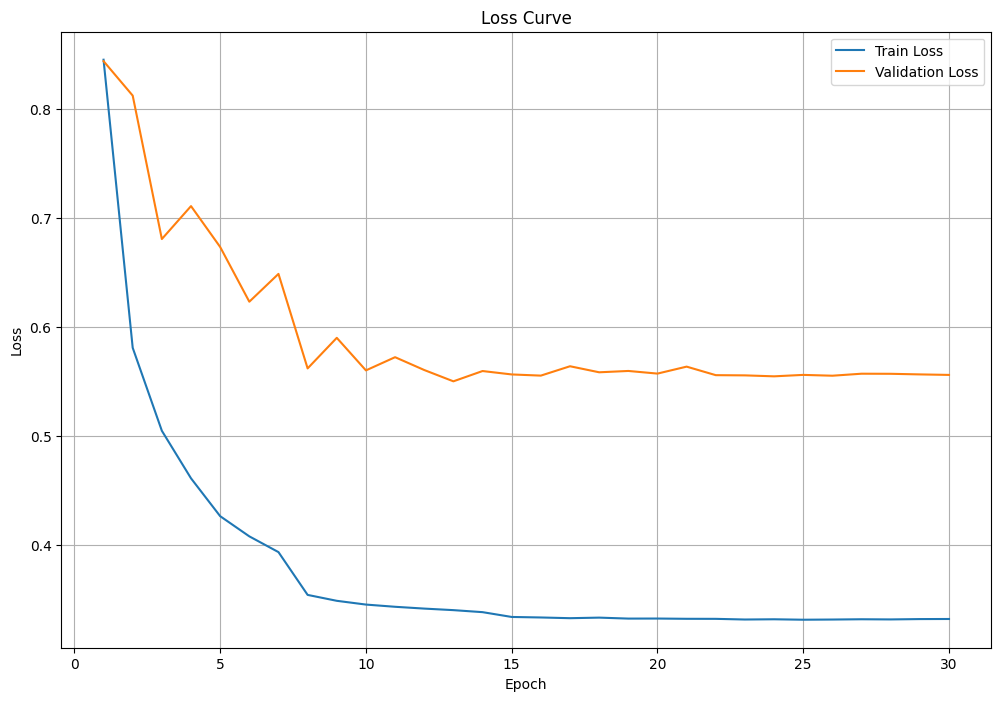

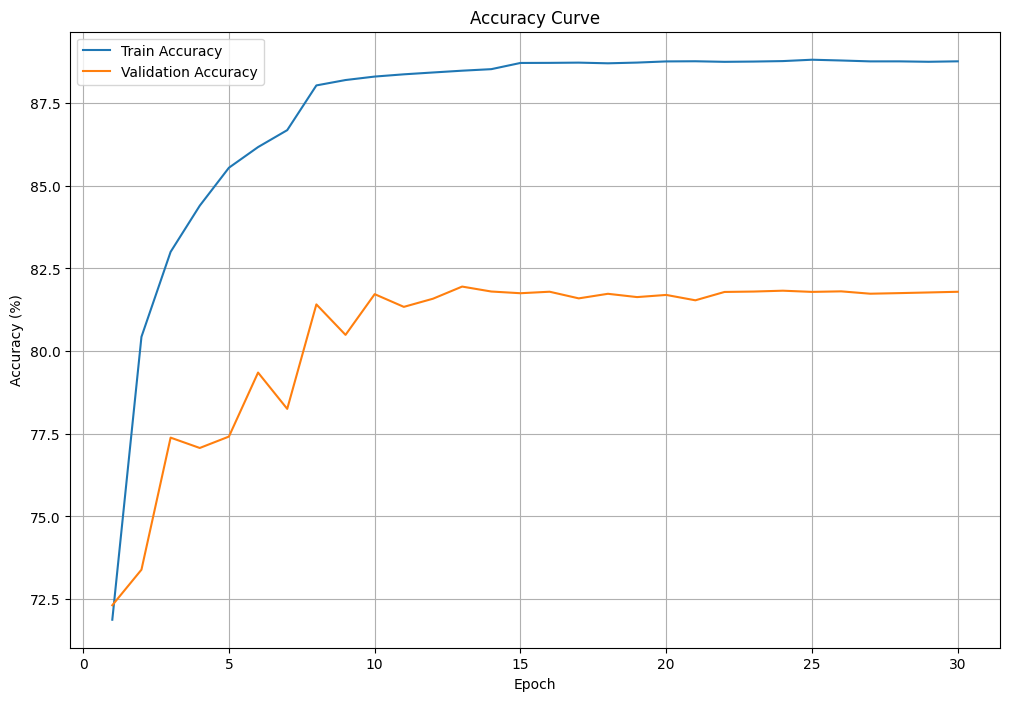

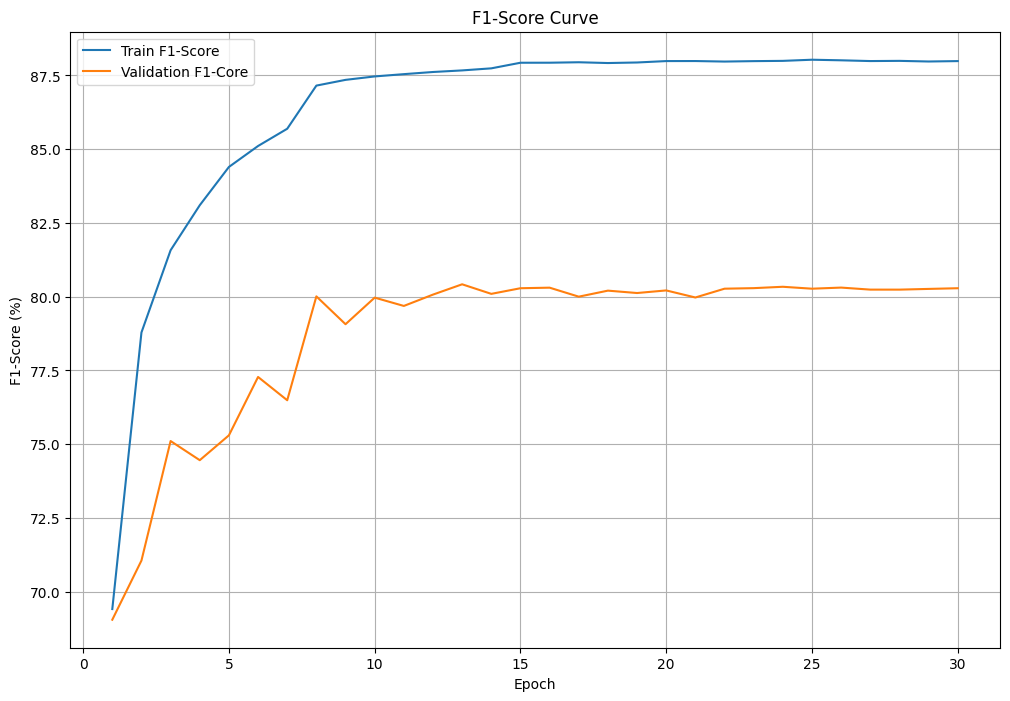

<Figure size 1200x800 with 0 Axes>

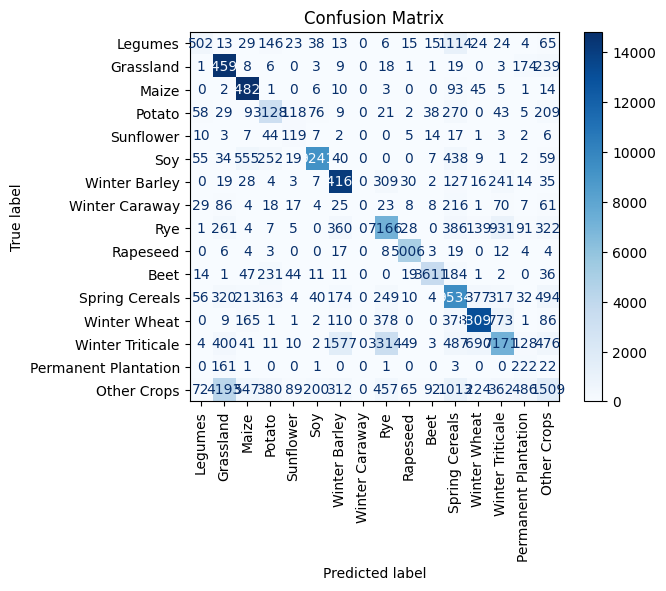

In [11]:
#---------------- Plotting -----------------
# Train/Val Loss
plt.figure(figsize=(12,8), num=1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(0, epochs+1, 5))
plt.legend()
plt.grid()
plt.title('Loss Curve')
plt.savefig(os.path.join(results_dir, "loss_curve.png"))

# Train/Val Accuracy
plt.figure(figsize=(12,8), num=2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.xticks(np.arange(0, epochs+1, 5))
plt.legend()
plt.grid()
plt.title('Accuracy Curve')
plt.savefig(os.path.join(results_dir, "accuracy_curve.png"))

# Train/Val F1-Score
plt.figure(figsize=(12,8), num=3)
plt.plot(range(1, epochs+1), train_f1s, label='Train F1-Score')
plt.plot(range(1, epochs+1), val_f1s, label='Validation F1-Core')
plt.xlabel('Epoch')
plt.ylabel('F1-Score (%)')
plt.xticks(np.arange(0, epochs+1, 5))
plt.legend()
plt.grid()
plt.title('F1-Score Curve')
plt.savefig(os.path.join(results_dir, "f1_score_curve.png"))

# Confusion Matrix
class_names = ['Legumes', 'Grassland', 'Maize', 'Potato', 'Sunflower', 'Soy', 'Winter Barley',
               'Winter Caraway', 'Rye', 'Rapeseed', 'Beet', 'Spring Cereals', 'Winter Wheat',
               'Winter Triticale', 'Permanent Plantation', 'Other Crops']
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(12,8), num=4)
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(values_format='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.savefig(os.path.join(results_dir, "confusion_matrix.png"))